<a href="https://colab.research.google.com/github/lorenzflow/FunctionalDeepLearning/blob/main/Thesis_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data set from drive



### mount drive

In [1]:
# connect drive to save models after training
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### load data and packages

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [ ]:
import glob
file_dir='./drive/My Drive/ThesisData/individual_stocks_5yr'
file_names = glob.glob('{}/*.csv'.format(file_dir))

In [ ]:
print(file_names[2])

./drive/My Drive/ThesisData/individual_stocks_5yr/AME_data.csv


In [ ]:
data = pd.read_csv(file_names[2])

In [ ]:
data.head

<bound method NDFrame.head of             date   open   high      low  close   volume Name
0     2013-02-08  41.22  41.57  41.0140  41.46   315562  AME
1     2013-02-11  41.37  41.52  40.9300  41.51   773702  AME
2     2013-02-12  41.51  41.98  41.3100  41.82   794051  AME
3     2013-02-13  41.87  42.04  41.6901  42.00   669581  AME
4     2013-02-14  41.81  42.01  41.7700  41.91   332685  AME
...          ...    ...    ...      ...    ...      ...  ...
1254  2018-02-01  77.31  78.51  76.1500  77.91  1625763  AME
1255  2018-02-02  77.84  78.37  77.1600  77.25  1949820  AME
1256  2018-02-05  76.78  77.46  73.8800  73.90  2557551  AME
1257  2018-02-06  72.41  75.32  71.5850  74.71  2698939  AME
1258  2018-02-07  74.25  75.00  74.1000  74.16  1569087  AME

[1259 rows x 7 columns]>

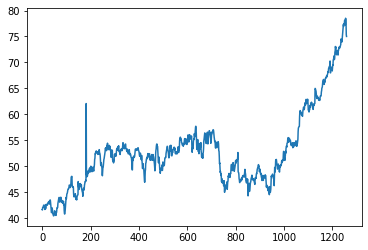

In [ ]:
import matplotlib.pyplot as plt

plt.plot(data['high'])

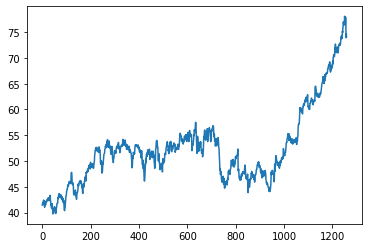

In [ ]:
plt.plot(data['close'])

In [ ]:

def load_dataset(batch_size, shuffle_buffer=None, file_dir='./drive/My Drive/ThesisData/individual_stocks_5yr'):
    """
    This function should create a tf.data.Dataset object for one of the train/valid/test
    splits, according to the above specification.
    It should then return the Dataset.
    """
    dataset = tf.data.Dataset.list_files('{}/*.csv'.format(file_dir), shuffle=False)
    
    def load_file(filepath):
        raw_data = np.read_csv(filepath) 
      
        return
    
    dataset = dataset.map(load_file)
    if shuffle_buffer is not None:
        dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Sample from GP
sampling from GP with RBF kernel to create train set for piVAE

In [1]:
from sklearn import gaussian_process
import numpy as np

In [2]:
GP = gaussian_process.GaussianProcessRegressor(optimizer='fmin_l_bfgs_b', 
                              n_restarts_optimizer=0, normalize_y=False, copy_X_train=True, random_state=None)

In [3]:
def sample_batch(batch_size, num_points, GP, lower, upper, x=None):
  if x==None:
    X = np.random.uniform(lower, upper, (batch_size,num_points))
    Y = np.zeros_like(X)
    for i in range(batch_size):
      Y[i,:] = np.squeeze(GP.sample_y(X[i,:].reshape(-1, 1)))
    return np.expand_dims(X,-1),np.expand_dims(Y,-1)
  else: # num_ points equally spaced points between lower and upper
    x = np.linspace(lower, upper, num_points)
    #for i in range(batch_size):
    Y = GP.sample_y(x[:, np.newaxis], batch_size)
    return x, np.expand_dims(Y,-1)
  


gp_dataset = [sample_batch(100, 100, GP, 0, 4, x=1) for i in range(5)]

In [4]:
X,Y = gp_dataset[1]
print(X.shape)
Y.shape

(100,)


(100, 100, 1)

# PiVAE

In [ ]:
!pip install scikit-fda

     |████████████████████████████████| 286kB 7.7MB/s 
     |████████████████████████████████| 4.0MB 35.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 962kB 24.8MB/s 
     |████████████████████████████████| 71kB 7.1MB/s 
  Created wheel for fdasrsf: filename=fdasrsf-2.3.1-cp37-cp37m-linux_x86_64.whl size=1503586 sha256=8638510c69592be6d3f393fc393851d1e3e5b17f2ac1d40e0b3e77c1c775a5b5
  Stored in directory: /root/.cache/pip/wheels/85/0f/48/237088e67ff4144f880004650d7f289bff69382bcacf128e15
Successfully built fdasrsf
  Created wheel for findiff: filename=findiff-0.8.9-cp37-none-any.whl size=29227 sha256=cfd6349d1521c83498f09fbc276a8a98cbac57ff48edd543bc65306286e974ce
  Stored in directory: /root/.cache/pip/wheels/11/24/9f/5f0a2414302f708f5cac01fede118615cb3679437787f1632f
  Created wheel for GPy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2564974 sha256=e

In [ ]:
from skfda.representation.basis import Fourier

 /usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.


In [ ]:
# Fourier Basis Layer, subclassing layer class
# evaluates a fourier basis functions up to dimensions n at each input 
from tensorflow.keras.layers import Layer

class FourierLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(FourierLayer, self).__init__(**kwargs)
        self.units = units # number of dimensions, needs to be odd as required by fourier basis
        self.basis = Fourier(n_basis=units) # fourier basis of  initialise basis

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        return self.basis(inputs)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [ ]:
import numpy as np
basis = Fourier(n_basis=40)
points = np.random.normal(size=(20,))

basis(points).shape

(41, 20, 1)

## online base implementation of the model

In [ ]:
# ---------------------------------------------------------
# TensorFlow piVAE Utils
# Licensed under The MIT License [see LICENSE for details]
# Written Lukas Adam
# Email: gm.lukas.adam@gmail.com
# ---------------------------------------------------------

def _pairwise_squared_distance_matrix(x):
    """Pairwise squared distance among a (batch) matrix's rows (2nd dim).
    This saves a bit of computation vs. using
    _cross_squared_distance_matrix(x,x)
    Args:
      x: `[batch_size, n, d]` float `Tensor`
    Returns:
      squared_dists: `[batch_size, n, n]` float `Tensor`, where
      squared_dists[b,i,j] = ||x[b,i,:] - x[b,j,:]||^2
    """

    x_x_transpose = tf.matmul(x, x, adjoint_b=True)
    x_norm_squared = tf.linalg.diag_part(x_x_transpose)
    x_norm_squared_tile = tf.expand_dims(x_norm_squared, 2)

    # squared_dists[b,i,j] = ||x_bi - x_bj||^2 =
    # = x_bi'x_bi- 2x_bi'x_bj + x_bj'x_bj
    squared_dists = x_norm_squared_tile - 2 * x_x_transpose + tf.transpose(
        x_norm_squared_tile, [0, 2, 1])

    return squared_dists


def _cross_squared_distance_matrix(x, y):
    """Pairwise squared distance between two (batch) matrices' rows (2nd dim).
    Computes the pairwise distances between rows of x and rows of y
    Args:
      x: [batch_size, n, d] float `Tensor`
      y: [batch_size, m, d] float `Tensor`
    Returns:
      squared_dists: [batch_size, n, m] float `Tensor`, where
      squared_dists[b,i,j] = ||x[b,i,:] - y[b,j,:]||^2
    """
    x_norm_squared = tf.reduce_sum(tf.square(x), 2)
    y_norm_squared = tf.reduce_sum(tf.square(y), 2)

    # Expand so that we can broadcast.
    x_norm_squared_tile = tf.expand_dims(x_norm_squared, 2)
    y_norm_squared_tile = tf.expand_dims(y_norm_squared, 1)

    x_y_transpose = tf.matmul(x, y, adjoint_b=True)

    # squared_dists[b,i,j] = ||x_bi - y_bj||^2 =
    # x_bi'x_bi- 2x_bi'x_bj + x_bj'x_bj
    squared_dists = (
        x_norm_squared_tile - 2 * x_y_transpose + y_norm_squared_tile)

    return squared_dists

def _phi(r, order=2, epsilon=0.0000000001):
        """Coordinate-wise nonlinearity used to define the order of the
        interpolation.
        See https://en.wikipedia.org/wiki/Polyharmonic_spline for the definition.
        Args:
          r: input op
          order: interpolation order
        Returns:
          phi_k evaluated coordinate-wise on r, for k = r
        """

        # using epsilon prevents log(0), sqrt0), etc.
        # sqrt(0) is well-defined, but its gradient is not
        with tf.name_scope('phi'):
            if order == 1:
                r = tf.maximum(r, epsilon)
                r = tf.sqrt(r)
                return r
            elif order == 2:
                return 0.5 * r * tf.math.log(tf.maximum(r, epsilon))
            elif order == 4:
                return 0.5 * tf.square(r) * tf.math.log(tf.maximum(r, epsilon))
            elif order % 2 == 0:
                r = tf.maximum(r, epsilon)
                return 0.5 * tf.pow(r, 0.5 * order) * tf.math.log(r)
            else:
                r = tf.maximum(r, epsilon)
                return tf.pow(r, 0.5 * order)

def _solve_interpolation(c, f, order=1, regularization_weight=1.0):
    # These dimensions are set dynamically at runtime.
    b, n, _ = tf.unstack(tf.shape(c), num=3)
        
    d = c.shape[-1]
    if d is None:
        raise ValueError('The dimensionality of the input points (d) must be '
                         'statically-inferrable.')
    
    k = f.shape[-1]
    if k is None:
        raise ValueError('The dimensionality of the output values (k) must be '
                         'statically-inferrable.')
        
    # Then calculate pairwise distance between centers
    pairwise_dists = _pairwise_squared_distance_matrix(c)
        
    # Transformed pairwise dists
    matrix_a = _phi(pairwise_dists, order=order) 
        
    ###########
        
    if regularization_weight > 0:
        batch_identity_matrix = tf.expand_dims(tf.eye(n, dtype=c.dtype), 0)
        matrix_a += regularization_weight * batch_identity_matrix

    # Append ones to the feature values for the bias term
    # in the linear model.
    ones = tf.ones_like(c[..., :1], dtype=c.dtype)
    matrix_b = tf.concat([c, ones], 2)  # [b, n, d + 1]

    # [b, n + d + 1, n]
    left_block = tf.concat(
            [matrix_a, tf.transpose(matrix_b, [0, 2, 1])], 1)

    num_b_cols = matrix_b.get_shape()[2]  # d + 1
    lhs_zeros = tf.zeros([b, num_b_cols, num_b_cols], c.dtype)
    right_block = tf.concat([matrix_b, lhs_zeros],
                                1)  # [b, n + d + 1, d + 1]
    lhs = tf.concat([left_block, right_block],
                        2)  # [b, n + d + 1, n + d + 1]

    rhs_zeros = tf.zeros([b, d + 1, k], c.dtype)
    rhs = tf.concat([f, rhs_zeros], 1)  # [b, n + d + 1, k]

    # Then, solve the linear system and unpack the results.
    with tf.name_scope('solve_linear_system'):
        linear_basis = tf.cast(tf.linalg.solve(lhs, rhs), tf.float64)
           
    return linear_basis

In [ ]:
# ---------------------------------------------------------
# TensorFlow piVAE Encoder & Decoder Models
# Licensed under The MIT License [see LICENSE for details]
# Written by Lukas Adam
# Email: gm.lukas.adam@gmail.com
# ---------------------------------------------------------

# Imports
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras import Model
from tensorflow.keras import backend as K

tfd = tfp.distributions

# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def _sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))

    return z_mean + K.exp(0.5 * (z_log_var)) * epsilon

##################################################

def vae_encoder(input_shape, intermediate_dim, latent_dim, sampling=_sampling):
    inputs = Input(shape=input_shape, name='encoder_input')
    x = Dense(intermediate_dim[0], activation='relu')(inputs)
    for i in intermediate_dim[1:]:
      x = Dense(i, activation='relu')(x)

    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # instantiate encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    return encoder

##################################################

def vae_decoder(latent_dim, intermediate_dim, original_dim):
    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim[-1], activation='relu')(latent_inputs)
    
    for i in intermediate_dim[-2::-1]:
      x = Dense(i, activation='relu')(x)

    outputs = Dense(original_dim)(x)

    # instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    
    return decoder

In [ ]:
# ---------------------------------------------------------
# TensorFlow piVAE Eager implementation
# Licensed under The MIT License [see LICENSE for details]
# Written by Lukas Adam
# Email: gm.lukas.adam@gmail.com
# ---------------------------------------------------------

# Imports

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras import Model
from tensorflow.keras import backend as K

#from models.vae import vae_encoder, vae_decoder
#from models.utils import _phi, _pairwise_squared_distance_matrix, _cross_squared_distance_matrix, _solve_interpolation

class piVAE:
    
    """
    Class containing the rebuild code basis for a prior encoding variational
    autoencoder. piVAE was implemented in TF 2.0.
    """
    
    def __init__(self, config):
        """
        
        Initialization
        
        Parameters:
        config (dict): build config for piVAE
        """
        
        # Store build config 
        self.config = config

        # Store latent distribution
        self.z_mean_list = []
        self.z_log_var_list = []
        
        # Define array to store all trainable variables here
        self.trainable_variables = []
        
        # Build model then
        self.__build__()
    
    #######################################################################################################################
        
    def __build__(self, init='normal'):
        """
        
        Function that loads standard VAE encoder and decoder modules and initializes weights for the trainable linear basis 
        Parameters:
        init (str): Type of weights initialization
        """
        
        # Load standard vae encoder and decoder from models
        
        self.encoder = vae_encoder(
            input_shape=self.config['encoder_dim']+2, 
            intermediate_dim=self.config['intermediate_dim'], 
            latent_dim=self.config['latent_dim']  
        )
        
        self.decoder = vae_decoder(
            latent_dim=self.config['latent_dim'],
            intermediate_dim=self.config['intermediate_dim'], 
            original_dim=self.config['encoder_dim']+2)
        
        # Now store all trainable variables
        
        self.trainable_variables.extend(self.encoder.trainable_variables)
        self.trainable_variables.extend(self.decoder.trainable_variables)
    
    #######################################################################################################################
    
    def __vae__(self, lb):
            
        """
        
        Standard VAE here
        """
        
        # Encode function proposals
        
        self.z_mean, self.z_log_var, self.z = self.encoder(lb)

        # append updated values to lists to check convergence
        self.z_mean_list.append(self.z_mean)
        self.z_log_var_list.append(self.z_log_var)
        
        # Decode latent sample and reconstruct linear basis
        lb_reconstruct = self.decoder(self.z)
            
        return lb_reconstruct
    
    #######################################################################################################################
       
    def __solve__(self, c, f):
        
        """
        
        Function that solves a linear system from the generated function values and real evaluations. 
        
        Returns: a linear basis abstracted from the equation
        
        """
        
        return _solve_interpolation(c, f, self.config['order'], self.config['regularization_weight'])
        
    #######################################################################################################################
    
    def __mat_op__(self, phi_dists, bias, w, v):
        
        rbf_term = tf.matmul(phi_dists, w)
        
        linear_term = tf.matmul(bias, v)
        
        return rbf_term + linear_term
        
    #######################################################################################################################
    
    def __eval__(self, c, linear_basis, f=None, q=None, training=True):
        
        # These dimensions are set dynamically at runtime.
        b, n, _ = tf.unstack(tf.shape(c), num=3)

        w = linear_basis[:, :n, :]
        v = linear_basis[:, n:, :]
            
        if training:
            # Then calculate pairwise distance between centers
            pairwise_dists = _pairwise_squared_distance_matrix(c)
        
            # Transformed pairwise dists
            phi_dists = _phi(pairwise_dists, order=self.config['order']) 
            
            # Then, compute the contribution from the linear term.
            # Pad query_points with ones, for the bias term in the linear model.
            bias = tf.concat([
                f,
                tf.ones_like(f[..., :1], c.dtype)
            ], 2)
            
        else:
            # First, compute the contribution from the rbf term.
            pairwise_dists = _cross_squared_distance_matrix(q, c)

            phi_dists = _phi(pairwise_dists, order=self.config['order'])

            # Then, compute the contribution from the linear term.
            # Pad query_points with ones, for the bias term in the linear model.
            bias = tf.concat([
                q,
                tf.ones_like(q[..., :1], c.dtype)
            ], 2)

        return self.__mat_op__(
                phi_dists=phi_dists,
                bias=bias,
                w=w,
                v=v
            )
       
      
    #######################################################################################################################
        
    def __train__(self, train_points, train_values, regularization_weight=1.0):
        
        """
        
        Function that is used when training the model. Eager execution is applied. 
        
        Requires:
        train points (np.ndarray): X-axis values
        """
        
        ###########################################
        
        # Squeeze and unsqueeze linear basis
        def squeeze(lb):
            return tf.squeeze(lb, axis=2)
        
        def unsqueeze(lb):
            return tf.cast(tf.expand_dims(lb, axis=2), tf.float64)
        
        ###########################################
        
        if not isinstance(train_points, np.ndarray) and not isinstance(train_values, np.ndarray):
            raise TypeError('training must be performed with numpy array')
        
        # First convert training points to tf
        train_points = tf.convert_to_tensor(train_points)
        train_values = tf.convert_to_tensor(train_values)
        
        ##################################################################
        
        linear_basis = self.__solve__(train_points, train_values)
        
        linear_basis_reconstruct = unsqueeze(self.__vae__(squeeze(linear_basis))) # here self.z_mean and self.z_log_var get updated
        
        ##################################################################
        
        # TO-DO: Try to also encode inverse element of vector by decoding a-a = 0 of z-mean
        
        ##################################################################
        
        return linear_basis, linear_basis_reconstruct, self.z_mean, self.z_log_var
    
    
##########################################################################

def pivae_loss(model, x, y=None, regularization_weight=1.0):
    
    def reconstruction_loss(y1, y2, loss_function='mse'):
        
        if loss_function == 'mae':
            loss = tf.reduce_sum(tf.keras.losses.MAE(y1, y2))
        elif loss_function == 'mse':
            loss = tf.reduce_sum(tf.keras.losses.MSE(y1, y2), axis=1)
        elif loss_function == 'msle':
            loss = tf.reduce_sum(tf.keras.losses.MSLE(y1, y2))
        else:
            raise ValueError('no loss function given!')
        return loss
    
    def kl_divergence_loss(z_mean, z_log_var):
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        kl_loss = tf.cast(kl_loss, tf.float64)
        return kl_loss
    
    # training=training is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    
    lb, lb_reconstruct, z_mean, z_log_var = model.__train__(x, y) 
    
    # Reconstruction loss - linear basis
    rl1 = reconstruction_loss(lb, lb_reconstruct)
    
    rl2 = reconstruction_loss(y, model.__eval__(c=x, linear_basis=lb_reconstruct, f=x))
    
    # KL divergence loss
    kl_loss = kl_divergence_loss(z_mean, z_log_var)

    # Total loss = 50% rec + 50% KL divergence loss
       
    loss = K.mean(rl1 + rl2 + kl_loss) 
    
    return loss

############################################################################

def pivae_grad(model, x, y, trainable_variables):
    with tf.GradientTape() as tape:
        loss_value = pivae_loss(model, x, y)
    return loss_value, tape.gradient(loss_value, trainable_variables)

In [ ]:
# Imports
import math
import random
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler

config = {
    'x_low': -4,
    'x_high': 4,
    'encoder_dim': 100,
    'batch_size': 100,
    'latent_dim': 5,
    'intermediate_dim': [70, 30, 10],
    'order': 2,
    'regularization_weight': 1
}

In [ ]:
X_ = np.expand_dims(np.expand_dims(np.linspace(-5, 5, 1000), axis=1), axis=0)

Text(0.5, 1.0, 'Prior Samples')

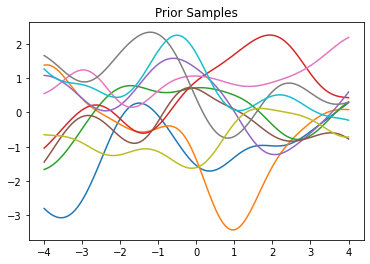

In [ ]:

# plot draws from gp priors
x, Y = sample_batch(10, 100, GP, -4, 4, x=1)
plt.plot(x, np.squeeze(Y))
plt.title("Prior Samples")

Text(0.5, 1.0, 'Prior Samples')

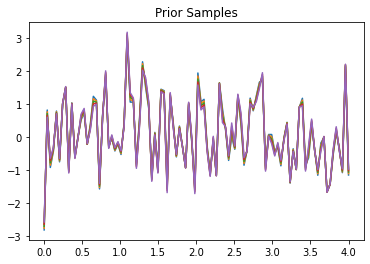

In [ ]:
import matplotlib.pyplot as plt

# plot draws from gp priors
for i in range(5):
    plt.plot(X, Y[i, :, 0])
plt.title("Prior Samples")

In [ ]:
linear_basis.shape

TensorShape([100, 102, 1])

In [ ]:
pivae = piVAE(config=config)

linear_basis = pivae.__solve__(X, Y)
Y_ = pivae.__eval__(c=X[0:1,:,:], linear_basis=linear_basis[0:1,:,:], q=X_, training=False)

Text(0.5, 1.0, 'Direct Interpolation')

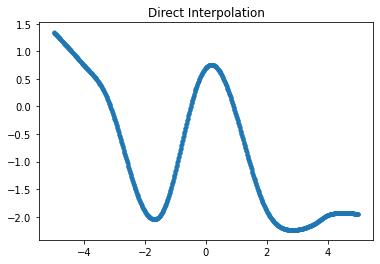

In [ ]:
for i in range(1):
    plt.scatter(X_[0, :, 0], Y_[i, :, 0], s=10)
plt.title("Direct Interpolation")

In [ ]:
model = pivae
loss = pivae_loss
grad = pivae_grad

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, decay=0.01, name='Adam'
)

In [ ]:
import os
import datetime

# Keep results for plotting
train_loss_results = []

num_epochs = 200

#log_dir = os.path.join(os.path.join(os.getcwd(), "logs"), datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#summary_writer = tf.summary.create_file_writer(logdir=log_dir)

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
  # Training loop - using batches of 32

  for X,Y in gp_dataset: #gp_dataset
    x_train, y_train = X,Y
    # Optimize the model
    loss_value, grads = grad(model, x_train, y_train, pivae.trainable_variables)
    optimizer.apply_gradients(zip(grads, pivae.trainable_variables))
    epoch_loss_avg(loss_value)  # Add current batch loss

  # End epoch
  train_loss_results.append(epoch_loss_avg.result().numpy())

  if epoch % 10 == 0:
    print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))

  #with summary_writer.as_default():
  #  tf.summary.scalar('epoch_loss_avg', epoch_loss_avg.result(), step=epoch)

Epoch 000: Loss: 246689.844
Epoch 010: Loss: 328.981
Epoch 020: Loss: 213.176
Epoch 030: Loss: 196.526
Epoch 040: Loss: 191.091
Epoch 050: Loss: 188.834
Epoch 060: Loss: 186.868
Epoch 070: Loss: 185.378
Epoch 080: Loss: 184.207
Epoch 090: Loss: 183.115
Epoch 100: Loss: 182.201
Epoch 110: Loss: 181.115
Epoch 120: Loss: 180.242
Epoch 130: Loss: 179.861
Epoch 140: Loss: 178.954
Epoch 150: Loss: 178.036
Epoch 160: Loss: 177.181
Epoch 170: Loss: 176.357
Epoch 180: Loss: 175.929
Epoch 190: Loss: 174.997


ValueError: ignored

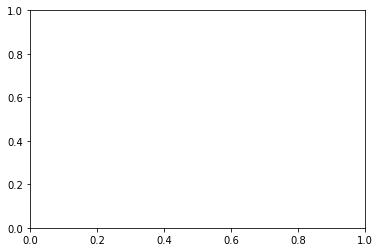

In [ ]:
# check posterior mean and variance have converged
for i in range(config['latent_dim']):
  plt.scatter(range(num_epochs),[x[i] for x in pivae.z_mean_list])

In [ ]:
pivae.z_mean_list[999]

<tf.Tensor: shape=(100, 5), dtype=float32, numpy=
array([[ 0.3019439 , -0.7670572 , -1.0584724 , -3.221465  , -1.4087156 ],
       [-0.84467417, -0.2733736 , -1.2150083 , -5.0306263 , -0.42833048],
       [ 0.20982829, -0.73087966, -1.0134652 , -3.0176404 , -1.2952919 ],
       [-1.4036156 , -0.47014207, -2.1928074 , -8.480926  , -0.7372602 ],
       [-0.31534535, -0.10055569, -0.62345886, -2.361866  , -0.34917685],
       [ 0.4763705 , -1.3001119 , -1.605381  , -4.925935  , -2.1816537 ],
       [ 0.05876694, -0.2812544 , -0.6280014 , -2.0083187 , -0.7569237 ],
       [-0.9108807 , -0.28460944, -1.3338008 , -5.3129516 , -0.4574037 ],
       [ 0.4328358 , -1.3256307 , -1.6416028 , -4.994152  , -2.1914256 ],
       [-0.63571554, -0.2421843 , -0.9974469 , -3.563261  , -0.4085156 ],
       [-0.5721279 , -0.17036544, -0.8597862 , -3.2773957 , -0.3168247 ],
       [-0.8217918 , -0.27057314, -1.194221  , -4.5495844 , -0.40022162],
       [ 0.15971367, -0.5744119 , -0.81127137, -2.4086297 , -1

## generating samples

In [ ]:
np.random.normal(loc=pivae.z_mean[0,:], scale=np.exp(pivae.z_log_var[0,:])**0.5, size=(config['latent_dim'],))

array([ 0.41216378, -0.66604002, -1.97818684, -3.93775975, -1.81979046])

In [ ]:
# sampling one basis vector and transforming with decoder and phi to reconstructed mean
def pi_vae_sampler(x, n, j=2):

  Z = np.random.normal(loc=pivae.z_mean[j,:], scale=np.exp(pivae.z_log_var[j,:])**0.5, size=(config['latent_dim'],)) # z_mu, z_sd
  reconstructed_mapping = tf.cast(tf.expand_dims(pivae.decoder(np.expand_dims(Z, 0)), -1), tf.float64)
  mean_reconstructed = pivae.__eval__(c=x, linear_basis=reconstructed_mapping, q=x, training=False)
  return np.squeeze(mean_reconstructed)

def pi_vae_sampler_X(x):
  Z = np.random.normal(loc=pivae.z_mean, scale=np.exp(pivae.z_log_var)**0.5, size=(100,config['latent_dim']))
  reconstructed_mapping = tf.cast(tf.expand_dims(pivae.decoder(Z), -1), tf.float64)
  mean_reconstructed = pivae.__eval__(c=x, linear_basis=reconstructed_mapping, q=x, training=False)
  return np.squeeze(mean_reconstructed)

In [ ]:
# generate n draws evaluated at points x
n = 10
x = np.expand_dims(np.expand_dims(np.linspace(-5,5,100), 0), -1)
sampled_mean = np.zeros((n, x.shape[1]))
for i in range(n):
  sampled_mean[i,:] = pi_vae_sampler(x,n, 10)
  #sampled_mean = pi_vae_sampler_X(x)

In [ ]:
sampled_mean.shape

(100, 100)

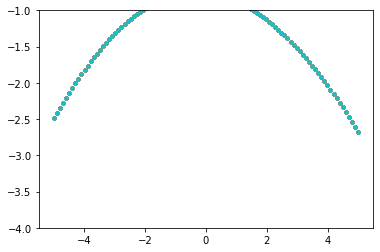

In [ ]:
# plot generated draws
for i in range(n):
  plt.scatter(np.squeeze(x), sampled_mean[i,:], s=10)
  plt.ylim(-4,-1)



## Inference with MH Sampler

In [ ]:
import math as m

In [ ]:
def mh_sampler(sample_size, x, y, sigma_prop, target=target):
  pi = tf.constant(m.pi)
  sample = np.zeros((sample_size+1,config['latent_dim']))
  Z_init = np.random.normal((config['latent_dim'],))
  sample[0,:] = Z_init
  accepted = 0
  def proposal(x, mean, std=sigma_prop):
    n = len(x)
    return tf.cast((2*pi)**(-n/2)* (tf.reduce_prod(sigma_prop**2))**(-0.5) * 
                   tf.math.exp( -1/2 * tf.linalg.matmul((x-mean), tf.linalg.matmul(tf.linalg.diag(sigma_prop**2), tf.transpose(x-mean)))), dtype= tf.float64) # np.exp( -1/2 * std**(-2) * np.sum((x-mean)**2))
  for i in range(sample_size):
    Z_prop = sample[i,:] + np.random.normal(scale=sigma_prop, size= config['latent_dim'])
    U = np.random.uniform()
  
    top_log_lik, top_prior = target(x, y, Z_prop)#*proposal(Z_prop, sample[i,:])
    bottom_log_lik, bottom_prior = target(x, y, sample[i,:])#*proposal(sample[i,:], Z_prop)
    lik_ratio = tf.math.exp(top_log_lik-bottom_log_lik) # using log-exp trick
    prior_ratio = top_prior/bottom_prior
    alpha = lik_ratio * prior_ratio
    #print(alpha)
    if U <= alpha:
      sample[i+1,:] = Z_prop
      accepted += 1
    else:
      sample[i+1,:] = sample[i,:]
  print(accepted)
  return sample

In [ ]:
def target(y, x, Z, sigma_noise=3): # need Z to be tf.float64
  # noise parameter sigma_noise inferred as well?
  # return log likelihood to use exp log trick
  pi = tf.constant(m.pi)
  reconstructed_mapping = tf.cast(tf.expand_dims(pivae.decoder(np.expand_dims(Z, 0)), -1), tf.float64)
  mean_reconstructed = pivae.__eval__(c=x, linear_basis=reconstructed_mapping, q=x, training=False)
  log_lik_eval = -1/2 * sigma_noise**(-2) * tf.math.reduce_sum((y - mean_reconstructed)**2)

  prior_eval = tf.cast((2*pi)**(-config['latent_dim']/2), tf.float64) * tf.math.exp(-1/2 * tf.math.reduce_sum(Z**2))
  return log_lik_eval, prior_eval

In [ ]:
## sample test data
x_te = np.random.uniform(-4,4, 100)
y_te = np.random.normal(x_te**2, scale=3)
x_te = np.expand_dims(np.expand_dims(x_te, -1), 0)
y_te = np.expand_dims(np.expand_dims(y_te, -1), 0)

In [ ]:
posterior_sample = mh_sampler(10**5, x_te, y_te, sigma_prop=posterior_sd)

96947


Mcmc does not converge properly...

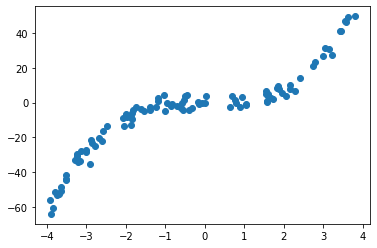

In [ ]:

plt.scatter(x_te,y_te)

In [ ]:
posterior_mean = tf.reduce_mean(posterior_sample[40000:,:], 0)

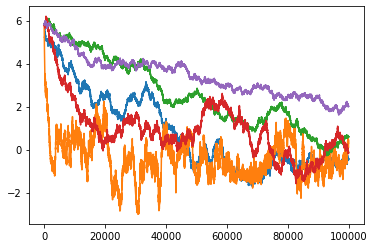

In [ ]:
# trace plot
for i in range(5):
  plt.plot(posterior_sample[:,i])

In [ ]:
posterior_sd = tf.reduce_mean((posterior_sample-posterior_mean)**2, 0)

In [ ]:
print(posterior_mean)
posterior_sd

tf.Tensor([4.55889276 3.97514671 5.36448849 5.04697504 5.50928303], shape=(5,), dtype=float64)


<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.0089867 , 0.03226995, 0.00643553, 0.01222307, 0.00558466])>

In [ ]:
final_Z = posterior_mean #+ np.random.normal(scale=(posterior_sd)**0.5)

In [ ]:
reconstructed_mapping = tf.cast(tf.expand_dims(pivae.decoder(np.expand_dims(final_Z, 0)), -1), tf.float64)
mean_recovered = pivae.__eval__(c=x_te, linear_basis=reconstructed_mapping, q=X_, training=False)

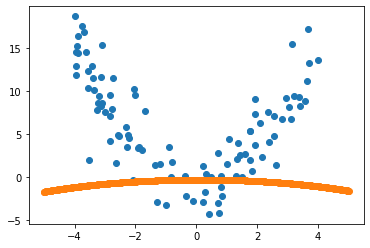

In [ ]:
plt.scatter(x_te,y_te)
plt.scatter(X_, mean_recovered)

# Deep O Net

### Own Implementation

#### using classes
Not tested yet

In [ ]:
# Build the piVAE Model object
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
import tensorflow as tf

In [ ]:

class branch_net(tf.keras.layers.Layer):
    """Maps inputs u(x_1),...u(x_n) to b_1,...,b_p
        Has argument branch_dims: list of 2 integers indicating layer width,
                     output_dim: dimension of the output before dot product, p """

    def __init__(self, branch_dims, output_dim = 32, name="branch_net", **kwargs):
        super(branch_net, self).__init__(name=name, **kwargs)
        self.dense_1 = Dense(branch_dims[0], activation="relu")
        self.dense_2 = Dense(branch_dims[0], activation="relu")
        self.dense_3 = Dense(output_dim)
        self.bn_1 = BatchNormalization()
        self.bn_2 = BatchNormalization()

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.bn_1(x)
        x = self.dense_2(x)
        x = self.bn_2(x)
        x = self.dense_3(x)
        return x

class trunk_net(tf.keras.layers.Layer):
    """Maps inputs y to t_1,...,t_p
      Has argument branch_dims: list of 2 integers indicating layer width,
                  output_dim: dimension of the output before dot product, p"""

    def __init__(self, trunk_dims, output_dim = 32 , name="trunk_net", **kwargs):
        super(trunk_net, self).__init__(name=name, **kwargs)
        self.trunk_dims = trunk_dims
        self.dense_1 = Dense(trunk_dims[0], activation="relu")
        self.dense_2 = Dense(trunk_dims[1], activation="relu")
        self.dense_3 = Dense(output_dim)

    def call(self, inputs):
        x = self.dense_1(inputs)
        #x = self.bn_1(x)
        x = self.dense_2(x)
        #x = self.bn_2(x)
        x = self.dense_3(x)
        return x


# not used yet, functional API instead
class DeepONet(tf.keras.Model):
    """Combines branch net and trunk net into an end-to-end model for training."""
    # currently 1-D y values, need additional input for higher dimensions
    def __init__(
        self,
        branch_dims,
        trunk_dims,
        output_dim,
        name="deeponet",
        **kwargs):
      
        super(DeepONet, self).__init__(name=name, **kwargs)
        self.branch_dims = branch_dims
        self.output_dim = output_dim
        self.trunk_dims = trunk_dims
        self.trunk = trunk_net(trunk_dims=trunk_dims, output_dim=output_dim)
        self.branch = branch_net(branch_dims=branch_dims, output_dim=output_dim)
        self.bias = tf.Variable(initial_value=0, trainable=True, name='bias')

    def call(self, inputs): # inputs is list of tensors or numpy arrays of the form [u(x), y]
        u_x, y = inputs
        b =  self.branch(u_x)
        t = self.trunk(y)
        G_y = tf.linalg.matmul(b, t, transpose_b=True) + self.bias 
        return G_y

In [ ]:
## generate some dummy inputs for the DeepONet
import numpy as np
x = np.linspace(0,1,20)
data = np.zeros((100*100, 21))
target = np.zeros((10**4,))
for i in range(100):
  a = np.random.normal(0, 9)
  y = np.random.uniform(0,1, size=(100,))
  u = np.cos(a*x)
  G_y = 1/a * np.sin(y)
  target[i*100: (i+1)*100] = G_y
  for j in range(100):
    data[j,:-1] = u
    data[j, 20] = y[j]

In [ ]:
# initialize model and compile
deeponet = DeepONet(branch_dims=[40,30], trunk_dims=[5,10], output_dim=20)
deeponet.compile(
    optimizer='adam', loss='rmse')

In [ ]:

u_x = np.expand_dims(data[1,:-1],0)
y = np.expand_dims(np.expand_dims(data[1,-1], 0),-1)
branch =  branch_net([40,40])
trunk = trunk_net([40,40])
b = branch(u_x)
t = trunk(y)
G_y = tf.linalg.matmul(b, t, transpose_b=True)

print(G_y)

tf.Tensor([[-0.01118785]], shape=(1, 1), dtype=float32)


In [ ]:
deeponet.summary()

Model: "deeponet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
trunk_net (trunk_net)        multiple                  0         
_________________________________________________________________
branch_net (branch_net)      multiple                  3340      
Total params: 3,341
Trainable params: 3,341
Non-trainable params: 0
_________________________________________________________________


#### Using functional API

In [ ]:
import numpy as np

num_sensors=40
y_dim=1

def gen_cos_integral(num_u=10**4, y_per_u=1, num_sensors=40, y_lower=0, y_upper=1, a_lower=-5, a_upper=5, y_dim=1):
  # generate data
  x = np.linspace(0,1,num_sensors)
  data = np.zeros((num_u*y_per_u, num_sensors+1))
  target = np.zeros((num_u*y_per_u,))
  for i in range(num_u):
    a = np.random.uniform(a_lower,a_upper)
    y = np.random.uniform(y_lower, y_upper, size=(y_per_u,))
    u = np.cos(x*(2*np.pi)*a)
    G_y = 1/(2*np.pi) / a * np.sin(y)

    target[i*y_per_u: (i+1)*y_per_u] = G_y
    data[i*y_per_u: (i+1)*y_per_u, -1] = y

    for j in range(i*y_per_u, (i+1)*y_per_u):
      data[j,:-1] = u
  return data[:, :-1], data[:, -1], target # u, y, G(u)(y)

In [ ]:

def get_deepOnet(num_sensors=100, branch_dims=[40,40], trunk_dims=[10,20], output_dim = 32, y_dim=1):
  u_input = tf.keras.Input(
      shape=(num_sensors,), name="u")
  y_input = tf.keras.Input(shape=(y_dim,), name="y")  

  branch =  branch_net(branch_dims, output_dim=output_dim) # output_dim=32 by default
  trunk = trunk_net(trunk_dims, output_dim=output_dim)

  b = branch(u_input)
  t = trunk(y_input)

  x = tf.keras.layers.Multiply()([b,t])
  pred = tf.reduce_sum(x)
  #pred = tf.linalg.matmul(b, t, transpose_b=True)

  # Instantiate an end-to-end model
  model = Model(
      inputs=[u_input, y_input],
      outputs=[pred],
  )
  return model


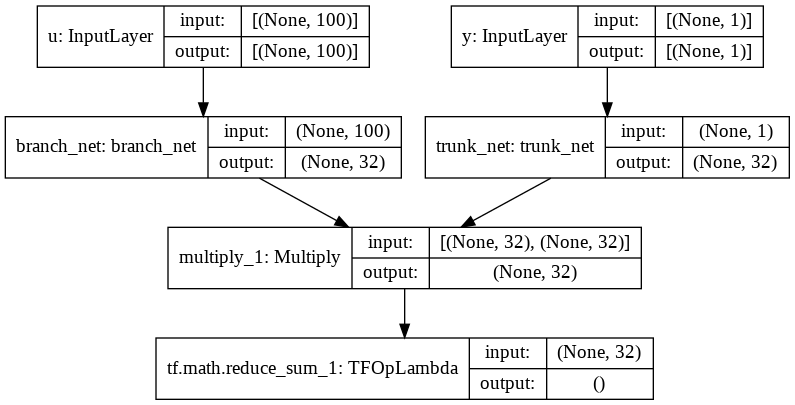

In [ ]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
model=get_deepOnet(num_sensors=40)
optimizer = tf.keras.optimizers.Adam(0.001) # lr as in paper for antiderivative
model.compile(
    optimizer=optimizer, loss='mse')

In [ ]:
u_data, y_data, target = gen_cos_integral(num_sensors=40, y_upper=1, y_per_u=100, num_u=100)

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=10)

history= model.fit({"u": u_data, "y": y_data}, target, validation_split=0.2, batch_size=89, epochs=200, shuffle=True, callbacks=[early_stopping])

Epoch 1/200
90/90 [==============================] - 1s 4ms/step - loss: 1.2444 - val_loss: 1.3511
Epoch 2/200
90/90 [==============================] - 0s 3ms/step - loss: 0.1113 - val_loss: 0.7102
Epoch 3/200
90/90 [==============================] - 0s 3ms/step - loss: 0.0833 - val_loss: 0.5303
Epoch 4/200
90/90 [==============================] - 0s 2ms/step - loss: 0.0785 - val_loss: 0.2485
Epoch 5/200
90/90 [==============================] - 0s 3ms/step - loss: 0.0572 - val_loss: 0.3064
Epoch 6/200
90/90 [==============================] - 0s 3ms/step - loss: 0.0540 - val_loss: 0.2993
Epoch 7/200
90/90 [==============================] - 0s 3ms/step - loss: 0.0557 - val_loss: 0.2535
Epoch 8/200
90/90 [==============================] - 0s 3ms/step - loss: 0.0513 - val_loss: 0.3090
Epoch 9/200
90/90 [==============================] - 0s 3ms/step - loss: 0.0641 - val_loss: 0.3659
Epoch 10/200
90/90 [==============================] - 0s 3ms/step - loss: 0.0768 - val_loss: 0.1769
Epoch 11/

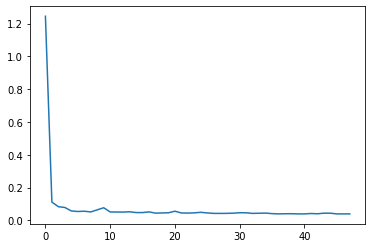

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
# generate test data and evaluate model on it
u_test, y_test, target_test = gen_cos_integral(num_sensors=40, y_upper=1, y_per_u=100, num_u=100)
model.evaluate({"u": u_test, "y": y_test}, target_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0479


0.047920212149620056

#### Try Deep-O-Net on Gaussian Process sample with numerical integration

In [ ]:
from sklearn.gaussian_process.kernels import RBF
import scipy.integrate as integrate
kernel = 1.0 * RBF(length_scale=0.2, length_scale_bounds=(1e-1, 10.0))
GP = gaussian_process.GaussianProcessRegressor(kernel=kernel, optimizer='fmin_l_bfgs_b', 
                              n_restarts_optimizer=0, normalize_y=False, copy_X_train=True, random_state=None)

In [ ]:
def get_data(num_functions=10**4, num_sensors=100, GP=GP, x_lower=0, y_lower=4):
  x, gp_sample = sample_batch(num_functions, num_sensors, GP, 0, 4, x=1)
  gp_sample = np.squeeze(gp_sample)
  gp_sample = np.transpose(gp_sample)

  ys = np.random.uniform(0,4,num_functions)
  targets = np.zeros(num_functions)
  for i in range(num_functions):
    x_ = x[x<=ys[i]]
    targets[i] = integrate.simps(gp_sample[i,:len(x_)], x_)
  return gp_sample, ys, targets

In [ ]:
gp_train, y_train, target_train = get_data(num_functions=2*10**4)


In [ ]:
gp_model=get_deepOnet(num_sensors=100, trunk_dims=[40,40], branch_dims=[500,500], output_dim=40)
optimizer = tf.keras.optimizers.Adam(0.001) # lr as in paper for antiderivative
gp_model.compile(
    optimizer=optimizer, loss='mse')

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=20)

history= gp_model.fit({"u": gp_train, "y": y_train}, target_train, validation_split=0.5, batch_size=100, epochs=400, shuffle=True, callbacks=[early_stopping])

Epoch 1/400
100/100 [==============================] - 2s 15ms/step - loss: 207.4455 - val_loss: 12.9770
Epoch 2/400
100/100 [==============================] - 1s 14ms/step - loss: 5.1757 - val_loss: 12.3849
Epoch 3/400
100/100 [==============================] - 1s 14ms/step - loss: 2.6913 - val_loss: 5.9118
Epoch 4/400
100/100 [==============================] - 1s 14ms/step - loss: 1.7905 - val_loss: 5.9835
Epoch 5/400
100/100 [==============================] - 1s 13ms/step - loss: 1.8003 - val_loss: 4.3592
Epoch 6/400
100/100 [==============================] - 1s 13ms/step - loss: 1.5671 - val_loss: 4.6606
Epoch 7/400
100/100 [==============================] - 1s 14ms/step - loss: 1.4559 - val_loss: 4.4109
Epoch 8/400
100/100 [==============================] - 1s 14ms/step - loss: 1.4111 - val_loss: 5.3875
Epoch 9/400
100/100 [==============================] - 1s 14ms/step - loss: 1.2833 - val_loss: 4.1268
Epoch 10/400
100/100 [==============================] - 1s 14ms/step - loss: 1

In [ ]:
# test against fully connected network

fnn = Sequential([
                  Dense(1000, input_shape=(101,), activation='relu'),
                  BatchNormalization(),
                  Dense(1000, activation='relu'),
                  BatchNormalization(),
                  Dense(1000, activation='relu'),
                  BatchNormalization(),
                  Dense(500, activation='relu'),
                  Dense(1)
              ])

fnn_model = Model(fnn.inputs, fnn.outputs)


In [ ]:
optimizer = tf.keras.optimizers.Adam(0.001) # lr as in paper for antiderivative
fnn_model.compile(
    optimizer=optimizer, loss='mse')

early_stopping = EarlyStopping(patience=10)

fnn_train_inputs = np.concatenate([gp_train, np.expand_dims(y_train, axis=-1)], axis=1)

history= fnn_model.fit(fnn_train_inputs, target_train, validation_split=0.5, batch_size=100, epochs=200, shuffle=True, callbacks=[early_stopping])

Epoch 1/200
100/100 [==============================] - 8s 69ms/step - loss: 1.1413 - val_loss: 0.3362
Epoch 2/200
100/100 [==============================] - 7s 68ms/step - loss: 0.3286 - val_loss: 0.2397
Epoch 3/200
100/100 [==============================] - 7s 69ms/step - loss: 0.1854 - val_loss: 0.1966
Epoch 4/200
100/100 [==============================] - 7s 68ms/step - loss: 0.1881 - val_loss: 0.1663
Epoch 5/200
100/100 [==============================] - 7s 68ms/step - loss: 0.1513 - val_loss: 0.1468
Epoch 6/200
100/100 [==============================] - 7s 68ms/step - loss: 0.1169 - val_loss: 0.1158
Epoch 7/200
100/100 [==============================] - 7s 68ms/step - loss: 0.0817 - val_loss: 0.1074
Epoch 8/200
100/100 [==============================] - 7s 68ms/step - loss: 0.0711 - val_loss: 0.0839
Epoch 9/200
100/100 [==============================] - 7s 68ms/step - loss: 0.0727 - val_loss: 0.1001
Epoch 10/200
100/100 [==============================] - 7s 68ms/step - loss: 0.065

This is not good!They achieve orders of magnitudes smaller error in the paper...


# Rough Paths signature

In [ ]:
!pip install iisignature
import numpy as np
import iisignature

## Trying out Signatory package

In [ ]:
!pip install signatory==1.2.4.1.7.1 --no-cache-dir --force-reinstall
import signatory
import torch
batch , stream , channels , depth = 1, 10, 2, 4

ERROR: Could not find a version that satisfies the requirement signatory==1.2.5 (from versions: 0.1.0, 0.1.1, 0.1.2, 0.2.0, 1.0.0, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.1.4.1.2.0, 1.1.4.1.3.0, 1.1.5.1.2.0, 1.1.5.1.3.0, 1.1.6.1.2.0, 1.1.6.1.3.0, 1.1.6.1.3.1, 1.2.0.1.2.0, 1.2.0.1.3.0, 1.2.0.1.3.1, 1.2.0.1.4.0, 1.2.1.1.2.0, 1.2.1.1.3.0, 1.2.1.1.3.1, 1.2.1.1.4.0, 1.2.1.1.5.0, 1.2.2.1.2.0, 1.2.2.1.3.0, 1.2.2.1.3.1, 1.2.2.1.4.0, 1.2.2.1.5.0, 1.2.2.1.5.1, 1.2.3.1.2.0, 1.2.3.1.3.0, 1.2.3.1.3.1, 1.2.3.1.4.0, 1.2.3.1.5.0, 1.2.3.1.5.1, 1.2.3.1.6.0, 1.2.4.1.6.0, 1.2.4.1.7.0, 1.2.4.1.7.1)
ERROR: No matching distribution found for signatory==1.2.5


In [ ]:
!python --version

Python 3.7.10


In [ ]:

!pip install torch==1.7.1 torchvision==0.8.2 torchaudio==0.7.2

ERROR: Could not find a version that satisfies the requirement signatory==1.2.5.1.7.1 (from versions: 0.1.0, 0.1.1, 0.1.2, 0.2.0, 1.0.0, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.1.4.1.2.0, 1.1.4.1.3.0, 1.1.5.1.2.0, 1.1.5.1.3.0, 1.1.6.1.2.0, 1.1.6.1.3.0, 1.1.6.1.3.1, 1.2.0.1.2.0, 1.2.0.1.3.0, 1.2.0.1.3.1, 1.2.0.1.4.0, 1.2.1.1.2.0, 1.2.1.1.3.0, 1.2.1.1.3.1, 1.2.1.1.4.0, 1.2.1.1.5.0, 1.2.2.1.2.0, 1.2.2.1.3.0, 1.2.2.1.3.1, 1.2.2.1.4.0, 1.2.2.1.5.0, 1.2.2.1.5.1, 1.2.3.1.2.0, 1.2.3.1.3.0, 1.2.3.1.3.1, 1.2.3.1.4.0, 1.2.3.1.5.0, 1.2.3.1.5.1, 1.2.3.1.6.0, 1.2.4.1.6.0, 1.2.4.1.7.0, 1.2.4.1.7.1)
ERROR: No matching distribution found for signatory==1.2.5.1.7.1
     |████████████████████████████████| 776.8MB 22kB/s 
     |████████████████████████████████| 12.8MB 254kB/s 
     |████████████████████████████████| 7.6MB 5.4MB/s 
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu10

In [ ]:
print(torch.__version__)
print(signatory.__version__)

1.7.1
1.2.4


In [ ]:
 path = torch.rand ( batch , stream , channels , requires_grad=True)
 signature = signatory.signature(path, depth)

signature

tensor([[ 0.6078, -0.6983,  0.1847, -0.0505, -0.3739,  0.2438,  0.0374, -0.0410,
          0.0514, -0.0642, -0.1393,  0.1637,  0.0487, -0.0567,  0.0057, -0.0075,
         -0.0024,  0.0092,  0.0180, -0.0172, -0.0403,  0.0308, -0.0342,  0.0274,
          0.0620, -0.0476,  0.0040, -0.0096, -0.0081,  0.0099]],
       grad_fn=<_SignatureFunctionBackward>)

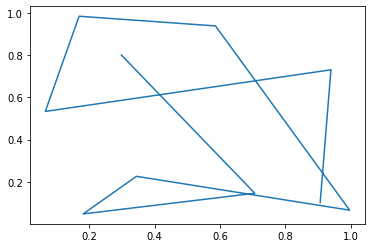

In [ ]:
import matplotlib.pyplot as plt

plt.plot(path.detach().numpy()[0,:,0], path.detach().numpy()[0,:,1])

In [ ]:
reconstructed_path = signatory.invert_signature(signature, depth=4, channels=2, initial_position=path[0,0,:])

AttributeError: ignored

## Sugar Spectra Regression with Signatures

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Sequential, Model
import glob
import pandas as pd
import numpy as np

In [ ]:

file_dir='./drive/My Drive/ThesisData/Sugar_csv'
file_names = glob.glob('{}/wave*'.format(file_dir))

def get_sugar_data(file_names=file_names):
  data = map(pd.read_csv, file_names)
  data = [d.values for d in data]
  return np.stack(data, axis=2)

def get_signatures(data, level=3):
  # data in dimensions b x n x p (batch size, measured points, measurement dimensions)
  return iisignature.sig(data, level)

In [ ]:
# load covariates and compute signature
data = get_sugar_data()
data = get_signatures(data)
X = data

In [ ]:
# load response
response = pd.read_csv('./drive/My Drive/ThesisData/Sugar_csv/response')
response = response['x']
#response = tf.cast(response, tf.float64)
y = response

In [ ]:
# cv
# X and y numpy arrays as loaded from drive
from sklearn.model_selection import KFold


def sig_net_cv(n_splits, layer_widths):

  kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)

  test_error = np.zeros(n_splits)
  train_error = np.zeros(n_splits)

  i = 0

  for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # prepare dataset
    train_dataset = prep(X_train, y_train)
    test_dataset = prep(X_test, y_test, batch_size = y_test.shape[0] , train=False)

    # get model and train
    model = get_signet(layer_widths)
    history = model.fit(train_dataset, validation_data=test_dataset, epochs = 30, verbose=0)

    train_error[i] = history.history['loss'][-1]
    test_error[i] = model.evaluate(test_dataset, verbose=0)[0]
    i += 1
  return tf.reduce_mean(train_error), tf.reduce_mean(test_error)

In [ ]:
def get_signet(layer_width, input_shape=(399,)):
  # function returns model with specified input shape and dense layers with layer widths given in array layer_width
  # Between each Dense Layer we have a BatchNormalization layer
  # Final Layer is a Dense Layer with one neuron for regression 1d output.
  # returns compiled model
  inputs = tf.keras.Input(shape=input_shape)   
  x = Dense(layer_width[0], activation='relu')(inputs)
  x = BatchNormalization()(x)
  for i in layer_width[1:]:
    x = Dense(i, activation='relu')(x)
    x = BatchNormalization()(x)

  outputs = Dense(1)(x)
  model = Model(inputs, outputs)

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
  loss = tf.keras.losses.MeanSquaredError()
  
  model.compile(optimizer=optimizer, loss=loss, metrics=['mae'])

  return model

In [ ]:
def prep(data, y, shuffle_buffer= 200, batch_size= 30, train=True):
  dataset = tf.data.Dataset.from_tensor_slices((data, y))
  if train:
    dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  return dataset

In [ ]:
mean_train_err, mean_test_err = sig_net_cv(5, [200,100,50,20])

In [ ]:
print(mean_train_err)
print(mean_test_err)

tf.Tensor(11.181789970397949, shape=(), dtype=float64)
tf.Tensor(19.00386600494385, shape=(), dtype=float64)


## Signature VAE

In [ ]:
# Build the encoder with KLAddLossLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers




#from tensorflow.keras.layers.experimental import RandomFourierFeatures
# assuming beta_i has 1x20 dims
latent_size=10
input_shape=(41,)

# Define the prior
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_size), scale=1), reinterpreted_batch_ndims=1)

encoder = Sequential([
    Dense(300, activation='relu', input_shape=input_shape), # adjust shape
    Dense(200, activation='relu', kernel_regularizer=l2(1e-4)),
    Dense(60, activation='relu', kernel_regularizer=l2(1e-4)),
    Dense(tfpl.IndependentNormal.params_size(latent_size)),
    tfpl.IndependentNormal(latent_size),
    tfpl.KLDivergenceAddLoss(prior, use_exact_kl=False, weight=1, test_points_fn= lambda q: q.sample(10), 
                             test_points_reduce_axis=None) # could possibly use exact KL divergence since Normal
          ])

decoder = Sequential([
    Dense(60, activation='relu', input_shape=(latent_size,)),
    Dense(200, activation='relu'),
    Dense(300, activation='relu'),
    Dense(tfpl.IndependentNormal.params_size(input_shape)),
    tfpl.IndependentNormal(input_shape)
          ])
    

In [ ]:
# combine encoder and decoder in model
from tensorflow.keras.models import Model
SigVAE = Model(encoder.inputs, decoder(encoder.outputs))




In [ ]:
x,Y = sample_batch(10**4, 100, GP, 0, 4, x=1)
Y = np.transpose(np.squeeze(Y))
Y = np.expand_dims(Y, axis=-1)

In [ ]:
X = np.zeros((10**4,100))
for i in range(10**4):
  X[i,:] = x
X = np.expand_dims(X,axis=-1)

In [ ]:
np.stack([X[0,:,0], Y[0,:,0]], axis=1).shape

(100, 2)

In [ ]:
s = iisignature.prepare(2, 7)
log_sigs = np.zeros((X.shape[0],41))
for i in range(X[0].shape[0]):
  log_sigs[i,:] = iisignature.logsig(np.stack([X[i,:,0], Y[i,:,0]], axis=1),s)

In [ ]:
# compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

SigVAE.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
history = SigVAE.fit(log_sigs, log_sigs, epochs=30, batch_size=100)

Epoch 1/30
100/100 [==============================] - 3s 10ms/step - loss: 1.3611
Epoch 2/30
100/100 [==============================] - 1s 10ms/step - loss: 0.4931
Epoch 3/30
100/100 [==============================] - 1s 10ms/step - loss: 0.0816
Epoch 4/30
100/100 [==============================] - 1s 11ms/step - loss: 0.0505
Epoch 5/30
100/100 [==============================] - 1s 11ms/step - loss: 0.0460
Epoch 6/30
100/100 [==============================] - 1s 11ms/step - loss: 0.0443
Epoch 7/30
100/100 [==============================] - 1s 11ms/step - loss: 0.0426
Epoch 8/30
100/100 [==============================] - 1s 12ms/step - loss: 0.0418
Epoch 9/30
100/100 [==============================] - 1s 14ms/step - loss: 0.0407
Epoch 10/30
100/100 [==============================] - 1s 13ms/step - loss: 0.0400
Epoch 11/30
100/100 [==============================] - 1s 11ms/step - loss: 0.0392
Epoch 12/30
100/100 [==============================] - 1s 12ms/step - loss: 0.0385
Epoch 13/30
1

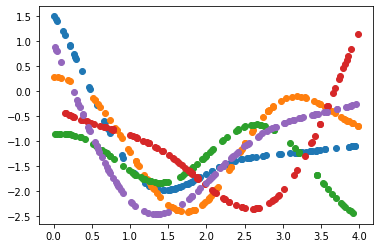

In [ ]:
# plot initial samples
import matplotlib.pyplot as plt
for i in range(5):
  plt.scatter(X[i,:,0], Y[i,:,0])

### Compute Gradients to retrieve path from signature

In [ ]:
def logsig_grads(path, pred_log_sig):
  '''Takes as input the path a numpy array of shape n x d, 
      and the target log signature we want the path to have.

      - Computes loss MSE(logsig(path),logsig_target)
      - Returns gradients dL/dpath'''


  gen_log_sig = iisignature.logsig(path,s) # requires numpy input
  gen_log_sig = tf.convert_to_tensor(gen_log_sig)
  with tf.GradientTape() as tape: # requires tensors
    tape.watch(gen_log_sig)
    loss = tf.reduce_mean((gen_log_sig-pred_log_sig)**2)
  derivs = tape.gradient(loss, gen_log_sig)
  grads = iisignature.logsigbackprop(derivs, path, s)
  grads = tf.convert_to_tensor(grads)
  return [grads, loss]


In [ ]:
# This initialisation of new path doesn't work
x_0 = X[0,:,0]+ 0.1
y_0 = np.random.normal(size=(100,))
path_init = np.stack([x_0, y_0], axis=1)
path = tf.Variable(
    initial_value= path_init, trainable=True
)
path = tf.cast(path, tf.float32)

In [ ]:
path = tf.Variable(
    initial_value= tf.random.normal(shape=(4,2), mean=[2,0]), trainable=True
)

InvalidArgumentError: ignored

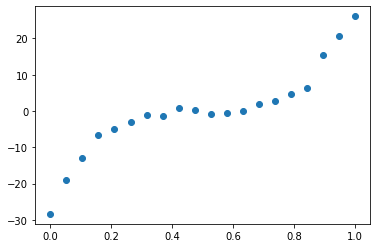

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(p[:,0], p[:,1])
plt.scatter(path[:,0], path[:,1])

### Example retrieving path from log-signature

Assuming the locations x known, we learn the y values of a path with the target log-signature by gradient descent. 

After gradient descent we still need to account for the reparametrisation invariance of the log-signature.

The first test case:
- x = -4,...4 in $R^n$, equally spaced points
- $y\sim \mathcal{N}(x^3, 1)$
So far the method works well for smaller n

In [ ]:
# generate target path
n = 10
x = np.linspace(0,1,n)
y = np.random.normal(loc=(6*(x-.5))**3, size=(n,))
y = y - np.mean(y)
p = np.stack([x,y], axis=1)

# compute log-signature up to level l
l = 12
s = iisignature.prepare(2, l)
log_sigs = iisignature.logsig(p, s)

In [ ]:
path = tf.Variable(initial_value= tf.random.normal(shape=(n,)), trainable=True)

In [ ]:

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

n_epochs=5000
pred_log_sig = log_sigs

losses = np.zeros(n_epochs)

for i in range(n_epochs):
  # use original locations and just learn y values
  grads, loss = logsig_grads(np.stack([x,path.numpy()], axis=1), pred_log_sig) # compute loss and gradients
  grads_y = grads[:,1] # extract gradients for y
  optimizer.apply_gradients(zip([grads_y], [path])) # apply gradients
  losses[i] = loss # append loss

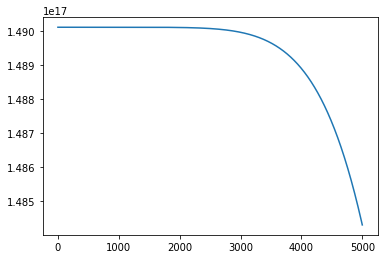

In [ ]:
plt.plot(losses)

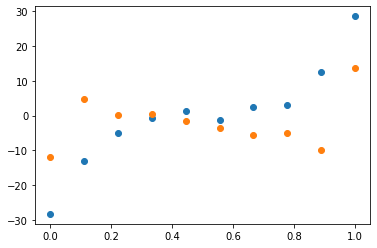

In [ ]:
# plot original data and infered path, both centered y.
plt.scatter(p[:,0], p[:,1])
plt.scatter(x, path)

In [ ]:
# Try retrieving it using signatory

# Fourier Transform

##Fourier Transform VAE

Should be better on smooth functions than signature
- problem with signature is inversion to retrieve path

### investigate symmetry in samples and reconstructions:

Decoder only produced real FT which then gives real even function after applying inverse fourier transform. Here we implement a potential fix by separating and concatenating real and even parts in the fourier transform, i.e. x +iy -> (x,y).

In [5]:
n_points = 100
x_upper = 4
X,Y_train = sample_batch(10**4, n_points, GP, 0, x_upper, x=1)
X,Y_val = sample_batch(10**3, n_points, GP, 0, x_upper, x=1)
# apply fourier transform to data
Y_train = np.transpose(np.squeeze(Y_train))
fourier_train = np.fft.fft(Y_train)

# apply fourier transform to data
Y_val = np.transpose(np.squeeze(Y_val))
fourier_val = np.fft.fft(Y_val)

In [6]:
# above changes to data
fourier_train = fourier_train[:,:(n_points//2)]
real_train = fourier_train.real
imag_train = fourier_train.imag

full_train = np.concatenate([real_train,imag_train], axis=1)

In [7]:
fourier_val = fourier_train[:,:(n_points//2)]
real_val = fourier_val.real
imag_val = fourier_val.imag

full_val = np.concatenate([real_val,imag_val], axis=1)

In [ ]:
full_train.shape

(10000, 800)

In [8]:
#from tensorflow.keras.layers.experimental import RandomFourierFeatures
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Model

tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

def get_VAE(input_shape, latent_size, prior, loss, optimizer, encoder_dims=[80,60,40], decoder_dims=[40,60,80]):
  encoder = Sequential([
      Dense(80, activation='relu', input_shape=input_shape), # adjust shape #
      Dense(60, activation='relu', kernel_regularizer=l2(1e-4)),
      Dense(40, activation='relu', kernel_regularizer=l2(1e-4)),
      Dense(tfpl.IndependentNormal.params_size(latent_size)),
      tfpl.IndependentNormal(latent_size),
      tfpl.KLDivergenceAddLoss(prior, use_exact_kl=False, weight=1, test_points_fn= lambda q: q.sample(10), 
                              test_points_reduce_axis=None) # could possibly use exact KL divergence since Normal
            ])

  decoder = Sequential([
      Dense(40, activation='relu', input_shape=(latent_size,)),
      Dense(60, activation='relu'),
      Dense(80, activation='relu'),
      Dense(tfpl.IndependentNormal.params_size(input_shape)),
      tfpl.IndependentNormal(input_shape)
            ])
      
  FVAE_concat = Model(encoder.inputs, decoder(encoder.outputs))
  FVAE_concat.compile(optimizer, loss=loss)
  # compile model
  return FVAE_concat, decoder, encoder
  
# get VAE
latent_size=10
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_size), scale=1), reinterpreted_batch_ndims=1)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.MeanSquaredError()
input_shape=(100,)
FVAE_concat, decoder, encoder = get_VAE(input_shape, latent_size, prior=prior, loss=loss, optimizer=optimizer)

early_stopping = EarlyStopping(patience=10)

history = FVAE_concat.fit(full_train, full_train, validation_data=(full_val, full_val), epochs=400, batch_size=100, callbacks=[early_stopping])



Epoch 1/400
100/100 [==============================] - 2s 8ms/step - loss: 111.1562 - val_loss: 89.1196
Epoch 2/400
100/100 [==============================] - 0s 5ms/step - loss: 84.1871 - val_loss: 80.8852
Epoch 3/400
100/100 [==============================] - 0s 5ms/step - loss: 79.3412 - val_loss: 78.1198
Epoch 4/400
100/100 [==============================] - 1s 5ms/step - loss: 77.2701 - val_loss: 76.4760
Epoch 5/400
100/100 [==============================] - 1s 5ms/step - loss: 74.9966 - val_loss: 72.5148
Epoch 6/400
100/100 [==============================] - 1s 6ms/step - loss: 66.1452 - val_loss: 57.6616
Epoch 7/400
100/100 [==============================] - 1s 5ms/step - loss: 49.0046 - val_loss: 41.3638
Epoch 8/400
100/100 [==============================] - 0s 5ms/step - loss: 37.9074 - val_loss: 35.3476
Epoch 9/400
100/100 [==============================] - 1s 5ms/step - loss: 34.1871 - val_loss: 33.4056
Epoch 10/400
100/100 [==============================] - 1s 5ms/step - lo

### Plot FFT_VAE reconstructions

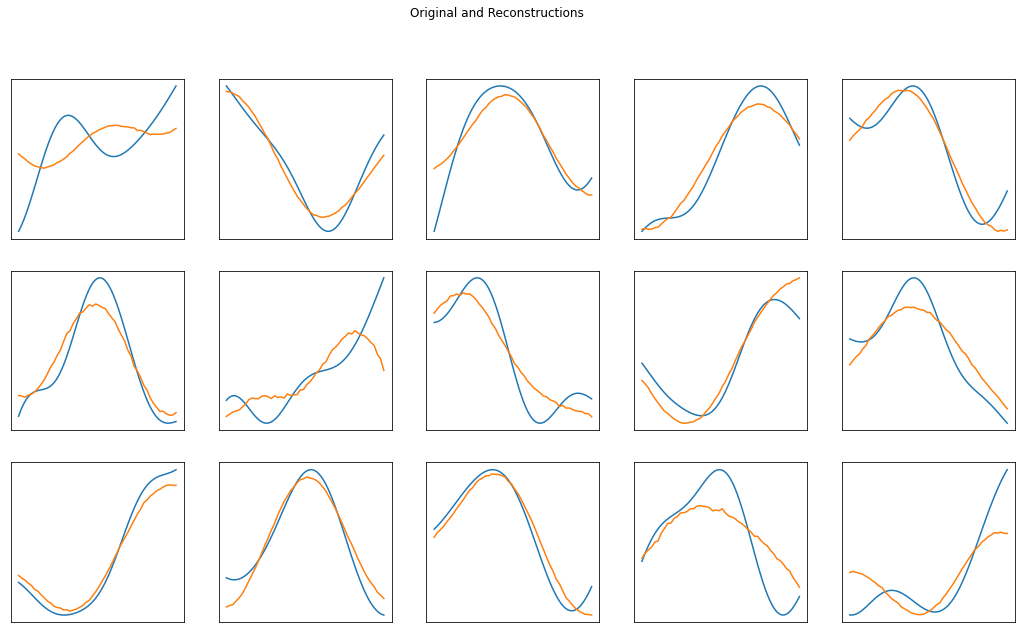

In [12]:
# sample test set
import matplotlib.pyplot as plt
X,Y_test = sample_batch(30, 100, GP, 0, 4, x=1)
Y_test = np.transpose(np.squeeze(Y_test))
Fourier_test = np.fft.fft(Y_test)
# above changes to data
Fourier_test = Fourier_test[:,:50]
real_test = Fourier_test.real
imag_test = Fourier_test.imag

full_test = np.concatenate([real_test,imag_test], axis=1)
out_test = FVAE_concat(full_test).mean()
out_ft = out_test[:,:50].numpy() + 1j * out_test[:,50:].numpy()

reconstructions = np.fft.ifft(out_ft)
# View the reconstructions and original

n_rows, n_cols = 3, 5
X_ = np.linspace(0,4, 50)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 10))
for i, ax in enumerate(fig.axes):
    ax.set_ylabel(str(i))
    ax.plot(X, Y_test[i,:]-np.mean(Y_test[i,:]), label='original')
    ax.plot(X_, reconstructions[i,:].real-np.mean(reconstructions[i,:].real), label='reconstructed')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #ax.legend(loc='upper right')
fig.suptitle('Original and Reconstructions')
plt.show()

### Use FFT_VAE to sample

Text(0.5, 1.0, 'GP samples')

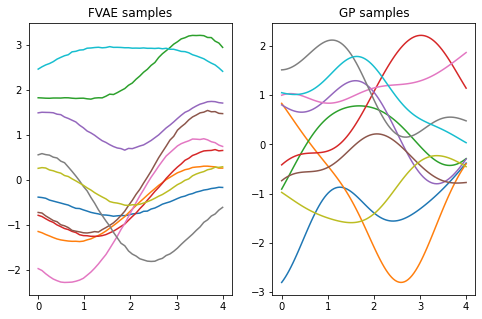

In [13]:
# sample and decode
n_samples = 20
samples= decoder(prior.sample(n_samples)).mean()

# inverse fourier transform
samples = np.fft.ifft(samples[:,:50].numpy() + 1j*samples[:,50:].numpy())

fig, axs = plt.subplots(1, 2, figsize=(8, 5))

for i in range(10):
  axs[0].plot(X_,samples[i,:].real)
  axs[1].plot(X, Y_test[i,:])
axs[0].set_title('FVAE samples')
axs[1].set_title('GP samples')

### Test marginals of samples against actual samples

In [15]:
X,Y_test = sample_batch(10**3, 50, GP, 0, 4, x=1)
Y_test = np.transpose(np.squeeze(Y_test))

n_samples = 10**3
samples= decoder(prior.sample(n_samples)).mean()

# inverse fourier transform
samples = np.fft.ifft(samples[:,:50].numpy() + 1j*samples[:,50:].numpy())

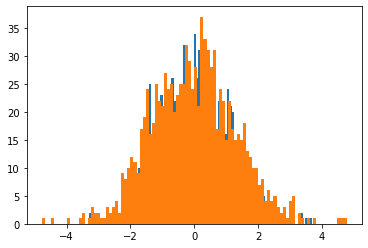

In [24]:
n = 49
_ = plt.hist(Y_test[:,n], bins=100)
_ = plt.hist(samples[:,n].real, bins=100)

### Try everything above but with a periodic kernel
Plotting the reconstructions clearly shows the periodicity constraint on the ability to reconstruct samples from the GP

#### Train

In [ ]:
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)


kernel = 1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(0.1, 10.0),
                                periodicity_bounds=(1.0, 10.0))

GP_exp_sine = gaussian_process.GaussianProcessRegressor(kernel = kernel, optimizer='fmin_l_bfgs_b', 
                              n_restarts_optimizer=0, normalize_y=False, copy_X_train=True, random_state=None)

# Build the encoder with KLAddLossLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers




#from tensorflow.keras.layers.experimental import RandomFourierFeatures
# assuming beta_i has 1x20 dims
latent_size=10
input_shape=(50,)

# Define the prior
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_size), scale=1), reinterpreted_batch_ndims=1)

encoder = Sequential([
    Dense(50, activation='relu', input_shape=input_shape), # adjust shape
    Dense(50, activation='relu', kernel_regularizer=l2(1e-4)),
    Dense(40, activation='relu', kernel_regularizer=l2(1e-4)),
    Dense(tfpl.IndependentNormal.params_size(latent_size)),
    tfpl.IndependentNormal(latent_size),
    tfpl.KLDivergenceAddLoss(prior, use_exact_kl=False, weight=1, test_points_fn= lambda q: q.sample(10), 
                             test_points_reduce_axis=None) # could possibly use exact KL divergence since Normal
          ])

decoder = Sequential([
    Dense(40, activation='relu', input_shape=(latent_size,)),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(tfpl.IndependentNormal.params_size(input_shape)),
    tfpl.IndependentNormal(input_shape)
          ])

In [ ]:
# combine encoder and decoder in model
from tensorflow.keras.models import Model
FVAE_exp = Model(encoder.inputs, decoder(encoder.outputs))

#write loss function as reconstructions loss

X,Y_train = sample_batch(10**4, 100, GP_exp_sine, 0, 4, x=1)
X,Y_val = sample_batch(10**3, 100, GP_exp_sine, 0, 4, x=1)

# apply fourier transform to data
Y_train = np.transpose(np.squeeze(Y_train))
fourier_train = np.fft.fft(Y_train)[:,:50]

# apply fourier transform to data
Y_val = np.transpose(np.squeeze(Y_val))
fourier_val = np.fft.fft(Y_val)[:,:50]

# compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

early_stopping = EarlyStopping(patience=10)

FVAE_exp.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
history_exp = FVAE_exp.fit(fourier_train, fourier_train, validation_data=(fourier_val, fourier_val), epochs=200, batch_size=100, callbacks=[early_stopping])



Epoch 1/200
100/100 [==============================] - 2s 6ms/step - loss: 233.3304 - val_loss: 174.9513
Epoch 2/200
100/100 [==============================] - 0s 4ms/step - loss: 152.6462 - val_loss: 140.6678
Epoch 3/200
100/100 [==============================] - 0s 4ms/step - loss: 134.4100 - val_loss: 130.5684
Epoch 4/200
100/100 [==============================] - 0s 4ms/step - loss: 127.2591 - val_loss: 124.5719
Epoch 5/200
100/100 [==============================] - 0s 3ms/step - loss: 119.0855 - val_loss: 111.3836
Epoch 6/200
100/100 [==============================] - 0s 4ms/step - loss: 99.1519 - val_loss: 83.2759
Epoch 7/200
100/100 [==============================] - 0s 4ms/step - loss: 68.6870 - val_loss: 56.3870
Epoch 8/200
100/100 [==============================] - 0s 3ms/step - loss: 50.2923 - val_loss: 46.5321
Epoch 9/200
100/100 [==============================] - 0s 4ms/step - loss: 43.6607 - val_loss: 42.3150
Epoch 10/200
100/100 [==============================] - 0s 3ms/

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


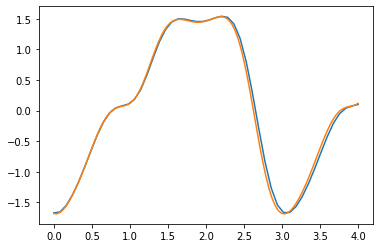

In [ ]:
y_rec = np.fft.ifft(fourier_val[1,:])
y_rec = y_rec - np.mean(y_rec)
plt.plot(np.linspace(0,4,50),y_rec)
plt.plot(X, Y_val[1,:]-np.mean(Y_val[1,:]))

#### plot reconstructions

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/

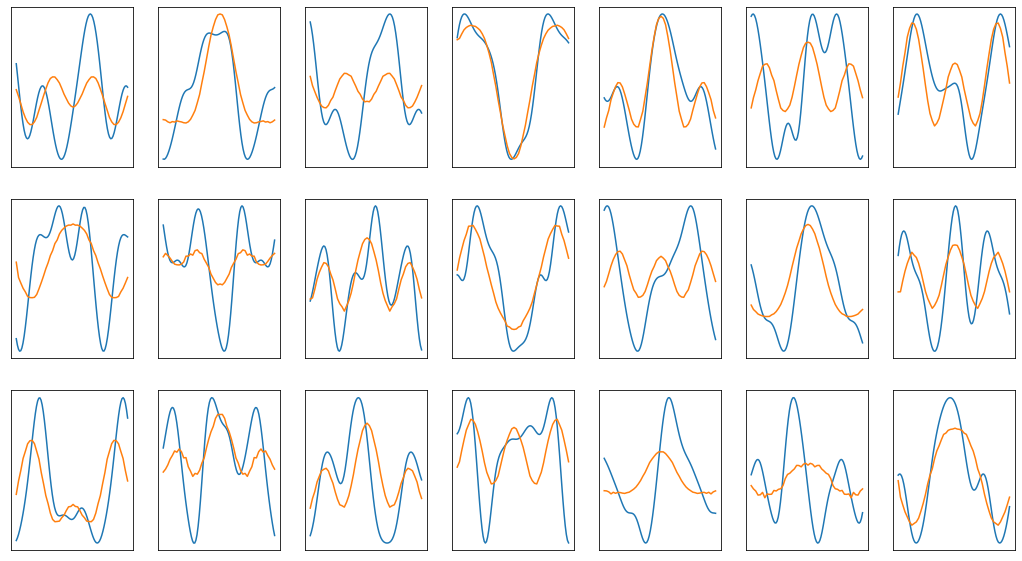

In [ ]:
# sample test set
X,Y_test = sample_batch(30, 100, GP_exp_sine, 0, 4, x=1)
Y_test = np.transpose(np.squeeze(Y_test))
Fourier_test = np.fft.fft(Y_test)[:,:50]

X_ = np.linspace(0,4,50)
reconstructions = np.fft.ifft(FVAE_exp(Fourier_test).mean())

# View the reconstructions and original
n_rows, n_cols = 3, 7

fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 10))
for i, ax in enumerate(fig.axes):
    ax.set_ylabel(str(i))
    ax.plot(X, Y_test[i,:]-np.mean(Y_test[i,:]), label='original')
    ax.plot(X_, reconstructions[i,:]-np.mean(reconstructions[i,:]), label='reconstructed')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #ax.legend(loc='upper right')
plt.show()

#### Generate samples

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'GP_exp_sine samples')

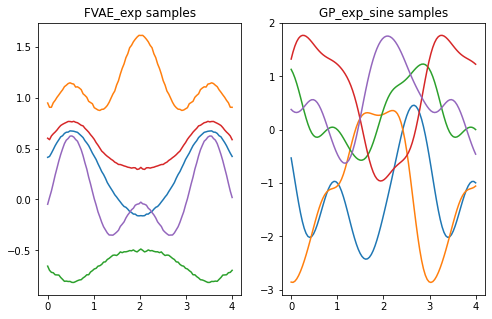

In [ ]:
# sample and decode
n_samples = 20
samples= decoder(prior.sample(n_samples)).mean()

# inverse fourier transform
samples = np.fft.ifft(samples)

fig, axs = plt.subplots(1, 2, figsize=(8, 5))

for i in range(5):
  axs[0].plot(X,samples[i,:])
  axs[1].plot(X, Y_test[i,:])
axs[0].set_title('FVAE_exp samples')
axs[1].set_title('GP_exp_sine samples')

### Fourier Transform VAE on Stock Data


In [2]:
import numpy as np

In [3]:
# load data
import pandas as pd
import glob
file_dir='./drive/My Drive/ThesisData/individual_stocks_5yr'
file_names = glob.glob('{}/*.csv'.format(file_dir))

stock_high_data=[]
for i in range(len(file_names)):
  stock = pd.read_csv(file_names[i])
  stock = stock['high']# extract daily highs
  stock_high_data.append(stock)

In [4]:
# number of NaN in data very small, just remove
sum([np.count_nonzero(np.isnan(x)) for x in stock_high_data])

stock_high_data = [x[~np.isnan(x)] for x in stock_high_data]

In [5]:
# check out one of the paths
short = pd.read_csv(file_names[3])
short.head()

,date,open,high,low,close,volume,Name
0,2017-07-17,75.0000,75.00,70.00,70.0000,33982,BHF
1,2017-07-18,70.5000,72.00,69.92,70.0000,35719,BHF
2,2017-07-19,67.9200,69.51,67.80,68.9500,1805,BHF
3,2017-07-20,69.7489,70.00,69.00,69.0000,28390,BHF
4,2017-07-21,70.0000,70.00,68.56,68.9226,1562,BHF


In [6]:
# only data streans with more than 500 points
# could use padding in ffr instead, might try later

def prep_data(min_length=1200, num_freq=100, stock_high_data=stock_high_data, normal=1):

  long_data = [x for x in stock_high_data if len(x)>min_length]
  if normal==None:
    normal = min([len(x) for x in long_data])
  # apply fourier transform to data
  # rfft to exploit redundancy for real input and speed up algorithm
  fourier_stock = [np.fft.rfft(x/normal) for x in long_data]
  # truncate after num_freq (0.5% even) frequencies, max can be n//2 + 1
  fourier_stock_trunc = [x[:num_freq] for x in fourier_stock]
  # stack rows
  fourier_stock_trunc = np.row_stack(fourier_stock_trunc)
  # concatenate real and imaginary parts and normalise
  real_stock = fourier_stock_trunc.real
  imag_stock = fourier_stock_trunc.imag
  full_stock = np.concatenate([real_stock,imag_stock], axis=1)

  input_shape = (2*num_freq,)

  return normal, full_stock, long_data, fourier_stock, input_shape

In [7]:
norm, full_stock, long_data, fourier_stock, input_shape = prep_data(min_length=1258,num_freq=50, normal=1)

In [172]:
len(long_data)

468

In [8]:
import matplotlib.pyplot as plt
def plot_fourier_rec(sample, num_fourier=[50, 100, 200], fourier_stock=fourier_stock, normal=norm):

  n_rows, n_cols = 3, 1
  
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 20))
  for i, ax in enumerate(fig.axes):
  
      l = len(fourier_stock[sample])
      fourier_rec = np.fft.irfft(np.concatenate([fourier_stock[sample][:num_fourier[i]], np.zeros(l - num_fourier[i])])).real * normal
      ax.set_ylabel(str(i))
      ax.set_title('N={}'.format(num_fourier[i]))
      ax.plot(long_data[sample])
      ax.plot(np.linspace(0,1259, len(fourier_rec)), fourier_rec)

      #ax.legend(loc='upper right')
  fig.suptitle('Original and truncated Fourier Transform reconstruction')
  plt.show()

In [9]:
l = len(fourier_stock[1])
len(np.concatenate([fourier_stock[1][:50], np.zeros(l - 50)]))

630

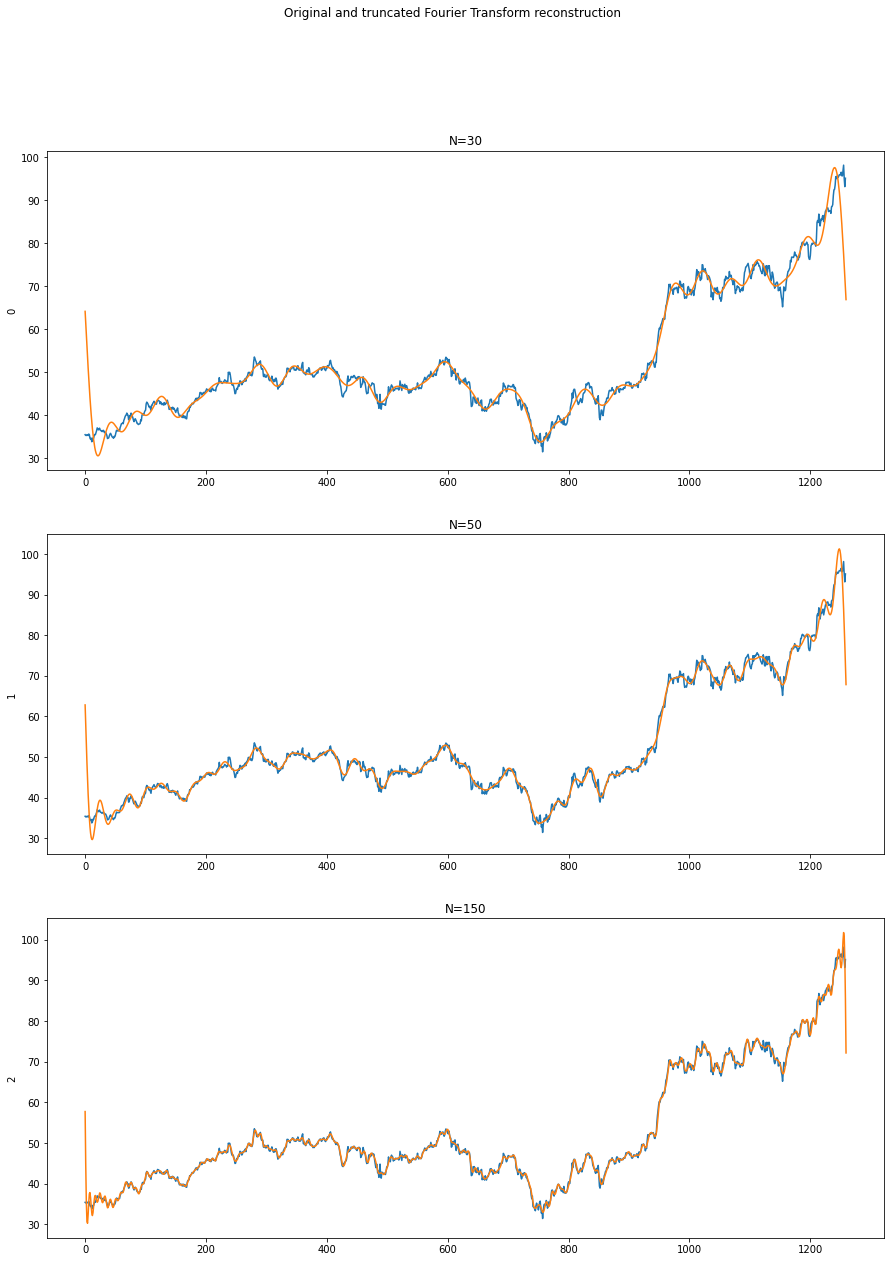

In [10]:
plot_fourier_rec(20, num_fourier=[30, 50, 150])

In [140]:
max_val = np.max(full_stock)
full_stock = full_stock/max_val

In [11]:
#np.count_nonzero(np.isnan(long_data))
print(np.argwhere(np.isnan(full_stock)))
print(full_stock.shape)

[]
(468, 100)


In [97]:
print(np.allclose(100*(np.fft.irfft(1/100 * (np.fft.rfft(long_data[1][:-1])))), long_data[1][:-1]))
print(np.allclose(np.fft.irfft(np.fft.rfft(long_data[1][:-1])), long_data[1][:-1]))

True
True


In [12]:
full_stock = full_stock/2500

In [13]:
# Build the encoder with KLAddLossLayer
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

from tensorflow.keras.callbacks import EarlyStopping
latent_size=10
#input_shape=(1200,)

# Define the prior
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_size), scale=1), reinterpreted_batch_ndims=1)

encoder = Sequential([
    Dense(80, activation='relu', input_shape=input_shape), # adjust shape
    Dense(60, activation='relu', kernel_regularizer=l2(1e-4)),
    Dense(60, activation='relu', kernel_regularizer=l2(1e-4)),
    Dense(40, activation='relu', kernel_regularizer=l2(1e-4)),
    #Dense(200, activation='relu', kernel_regularizer=l2(1e-4)),
    Dense(tfpl.IndependentNormal.params_size(latent_size)),
    tfpl.IndependentNormal(latent_size),
    tfpl.KLDivergenceAddLoss(prior, use_exact_kl=False, weight=1, test_points_fn= lambda q: q.sample(10), 
                             test_points_reduce_axis=None) # could possibly use exact KL divergence since Normal
          ])

decoder = Sequential([
    Dense(40, activation='relu', input_shape=(latent_size,)),
    Dense(60, activation='relu'),
    Dense(60, activation='relu'),
    Dense(80, activation='relu'),
    #Dense(1200, activation='relu'),
    Dense(tfpl.IndependentNormal.params_size(input_shape)),
    tfpl.IndependentNormal(input_shape)
          ])
    

# compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
#early_stopping = EarlyStopping(patience=30)

FVAE_concat = Model(encoder.inputs, decoder(encoder.outputs))
FVAE_concat.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
history = FVAE_concat.fit(full_stock, full_stock,  epochs=400, batch_size=20) #,callbacks=[early_stopping])

Epoch 1/400
24/24 [==============================] - 2s 3ms/step - loss: 69.8242
Epoch 2/400
24/24 [==============================] - 0s 3ms/step - loss: 53.7129
Epoch 3/400
24/24 [==============================] - 0s 3ms/step - loss: 47.3749
Epoch 4/400
24/24 [==============================] - 0s 3ms/step - loss: 44.2329
Epoch 5/400
24/24 [==============================] - 0s 4ms/step - loss: 42.7645
Epoch 6/400
24/24 [==============================] - 0s 3ms/step - loss: 42.0914
Epoch 7/400
24/24 [==============================] - 0s 3ms/step - loss: 41.3342
Epoch 8/400
24/24 [==============================] - 0s 3ms/step - loss: 41.0506
Epoch 9/400
24/24 [==============================] - 0s 3ms/step - loss: 40.5964
Epoch 10/400
24/24 [==============================] - 0s 3ms/step - loss: 40.2139
Epoch 11/400
24/24 [==============================] - 0s 3ms/step - loss: 39.5639
Epoch 12/400
24/24 [==============================] - 0s 3ms/step - loss: 39.0471
Epoch 13/400
24/24 [=====

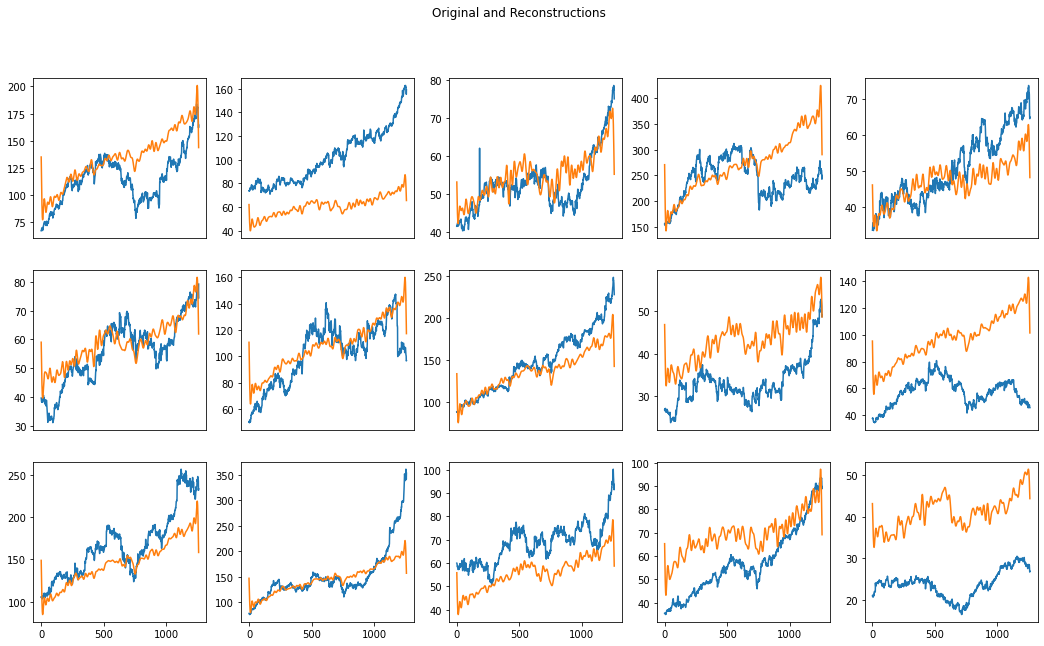

In [16]:
num_freq=50
num_examples = 20

out_test = FVAE_concat(full_stock[:num_examples,:]).mean()
out_ft = (out_test[:,:num_freq].numpy() + 1j * out_test[:,num_freq:].numpy())* 2500
#l = len(fourier_stock[1])
#fourier_rec = np.fft.irfft(np.concatenate([out_ft, np.zeros((num_examples,l - num_freq))], axis=1))

#tester = [np.fft.irfft(x) for x in fourier_stock[:num_examples]]

reconstructions = fourier_rec
# View the reconstructions and original

n_rows, n_cols = 3, 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 10))
for i, ax in enumerate(fig.axes):
    l = len(fourier_stock[i])
    fourier_rec = np.fft.irfft(np.concatenate([out_ft[i,:], np.zeros((l - num_freq))]))
    X = np.linspace(0,1259, len(long_data[i]))
    X_ = np.linspace(0,1259, len(fourier_rec))

    #ax.set_ylabel(str(i))
    ax.plot(X, long_data[i], label='original')
    #ax.plot(X_, reconstructions[i,:].real, label='reconstructed')
    ax.plot(X_, fourier_rec.real, label='reconstructed')
    #ax.set_ylim([-15,15])
    #if i!=0 and i!=5 and i!=10:
    #  ax.get_yaxis().set_visible(False)
    if i<10:
      ax.get_xaxis().set_visible(False)
    #ax.legend(loc='upper right')
fig.suptitle('Original and Reconstructions')
plt.show()

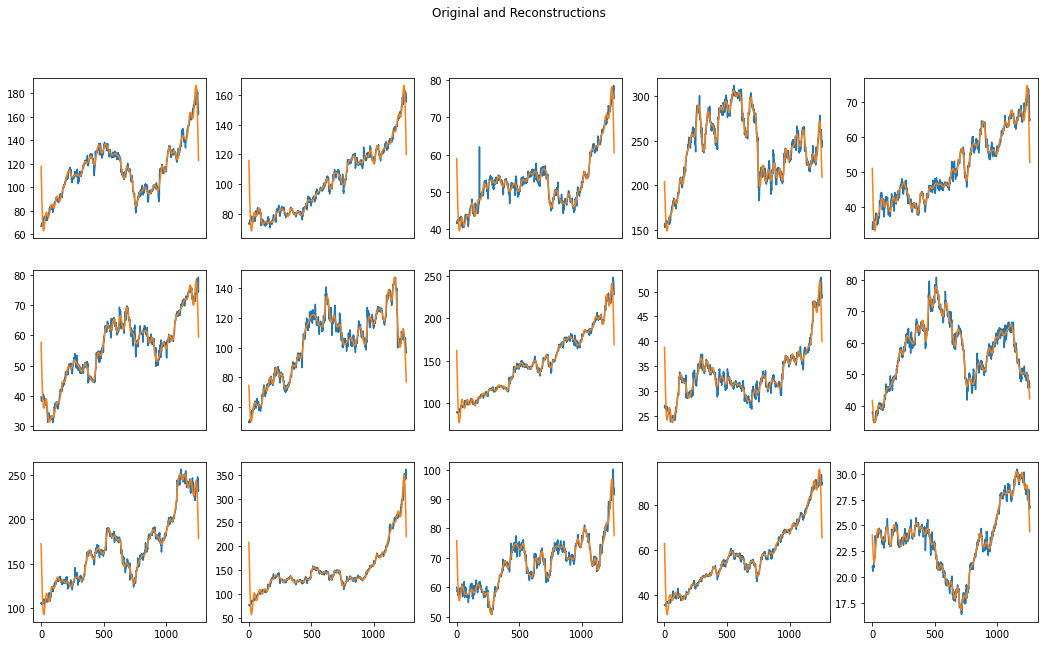

In [178]:
num_freq=50
num_examples = 20


out_ft = (full_stock[:num_examples,:num_freq] + 1j * full_stock[:num_examples,num_freq:])* 3000
l = len(fourier_stock[1])
fourier_rec = np.fft.irfft(np.concatenate([out_ft, np.zeros((num_examples,l - num_freq))], axis=1))

#tester = [np.fft.irfft(x) for x in fourier_stock[:num_examples]]

reconstructions = fourier_rec
# View the reconstructions and original

n_rows, n_cols = 3, 5
X = np.linspace(0,1259, len(long_data[i]))
X_ = np.linspace(0,1259, len(fourier_rec[1,:]))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 10))
for i, ax in enumerate(fig.axes):
    #ax.set_ylabel(str(i))
    ax.plot(X, long_data[i], label='original')
    ax.plot(X_, reconstructions[i,:].real, label='reconstructed')
    #ax.set_ylim([-15,15])
    #if i!=0 and i!=5 and i!=10:
    #  ax.get_yaxis().set_visible(False)
    if i<10:
      ax.get_xaxis().set_visible(False)
    #ax.legend(loc='upper right')
fig.suptitle('Original Perfect Fourier Interpolation')
plt.show()

Text(0.5, 1.0, 'GP samples')

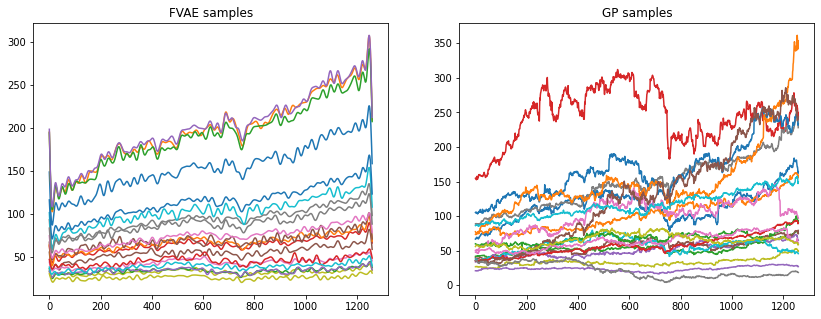

In [18]:
# sample and decode
n_samples = 20
num_freq=50
samples= decoder(prior.sample(n_samples)).mean()*2500
#X_ = np.linspace(0,800,400)
# inverse fourier transform
ft = samples[:,:num_freq].numpy() + 1j*samples[:,num_freq:].numpy()
samples = np.fft.irfft(np.concatenate([ft, np.zeros((n_samples, l-num_freq))], axis=1))

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

for i in range(0,20):
  axs[0].plot(X_,samples[i,:].real)
  axs[1].plot(X, long_data[i])
axs[0].set_title('FVAE samples')
axs[1].set_title('GP samples')

### FFt VAE split each stream into junks to increase dataset size

### Just some fourier transform code to test fft.fft()

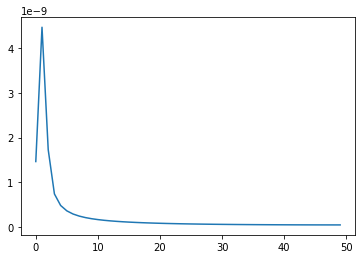

In [ ]:
tpCount     = len(Y)

values      = np.arange(int(tpCount/2))

timePeriod  = tpCount/100

frequencies = values/timePeriod
plt.plot(frequencies, abs(fourier))

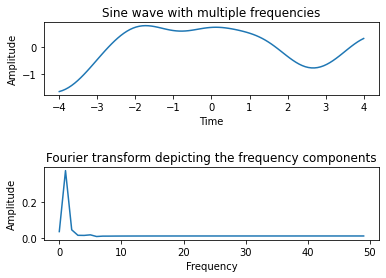

In [ ]:
# Python example - Fourier transform using numpy.fft method

import numpy as np

import matplotlib.pyplot as plotter

 

# How many time points are needed i,e., Sampling Frequency

samplingFrequency   = 100;

 

# At what intervals time points are sampled

samplingInterval       = 1 / samplingFrequency;

 

# Begin time period of the signals

beginTime           = -4;

 

# End time period of the signals

endTime             = 4; 

x, Y = sample_batch(10, samplingFrequency, GP, beginTime, endTime, x=1)

# Frequency of the signals

#signal1Frequency     = 5;

#signal2Frequency     = 9;

time = x

# Time points
amplitude = Y[:,2,0]
 

# Create two sine waves

#amplitude1 = np.sin(2*np.pi*signal1Frequency*time)

#amplitude2 = np.sin(2*np.pi*signal2Frequency*time)

 

# Create subplot

figure, axis = plotter.subplots(2, 1)

plotter.subplots_adjust(hspace=1)

 

# Add the sine waves

#amplitude = amplitude1 + amplitude2

 

# Time domain representation of the resultant sine wave

axis[0].set_title('Sine wave with multiple frequencies')

axis[0].plot(time, amplitude)

axis[0].set_xlabel('Time')

axis[0].set_ylabel('Amplitude')

 

# Frequency domain representation

fourierTransform = np.fft.fft(amplitude)/len(amplitude)           # Normalize amplitude

fourierTransform = fourierTransform[range(int(len(amplitude)/2))] # Exclude sampling frequency

fourierTransform = fourierTransform.real

tpCount     = len(amplitude)

values      = np.arange(int(tpCount/2))

timePeriod  = tpCount/samplingFrequency

frequencies = values/timePeriod

 

# Frequency domain representation

axis[1].set_title('Fourier transform depicting the frequency components')

 

axis[1].plot(frequencies, abs(fourierTransform))

axis[1].set_xlabel('Frequency')

axis[1].set_ylabel('Amplitude')

 

plotter.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


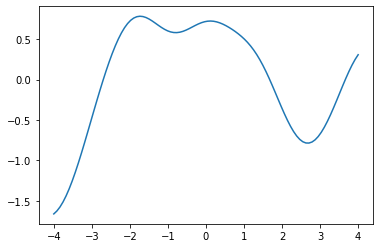

In [ ]:
fourierTransform = np.fft.fft(amplitude)
plt.plot(time, np.fft.ifft(fourierTransform))

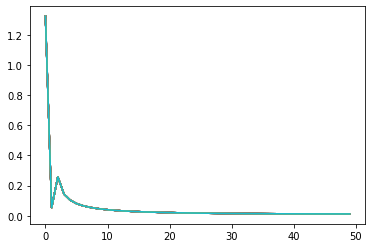

In [ ]:
import matplotlib.pyplot as plt
for i in range(30):
  plt.plot(frequencies, abs(fourier[i,:]))